In [3]:
# Verify kernel and packages
import sys
print("sys.executable:", sys.executable)
try:
    import cv2
    print("cv2 version:", cv2.__version__)
except Exception as e:
    print("cv2 import failed:", e)


sys.executable: c:\ProgramData\anaconda3\python.exe
cv2 version: 4.12.0


# **Butterfly Species Classification**

This is an image classification problem, and the model will be trained using CNN. 

**Business Problem** As we all know, the presence of **butterflies** can serve as a key measure of environmental well-being. Manual processes require both time and knowledge, which is time-consuming. I am making it feasible for large-scale research. Given these challenges, automating the **Butterfly species** classification process through ML offers a solution to the wildlife conservations and enables researchers to take quick decisions.

**Importance** By automating this process, companies and research institutions involved in biodiversity conservation can reduce the dependency on expert knowledge for the same and make the system more efficient and accessible to more users. This will enhance their position in **the wildlife conservation** market by providing a more aligned solution.

## Dataset Overview

The dataset includes 832 butterfly images divided among 10 species. Each image is labeled with its corresponding butterfly type. Key attributes of the dataset include:

- **Image Path**: File path of the image.
- **Label**: The butterfly species name.

Data is accessible below 

[Butterfly Dataset on Kaggle](https://www.kaggle.com/datasets/veeralakrishna/butterfly-dataset)


## **Data Exploration**

**Importing libraries and Loading Data**

In [4]:
#%python3.10 -m venv tf_env
#%source tf_env/bin/activate
#%pip install opencv-python 
%pip install jinja2

import os
import cv2
import zipfile
import numpy as nps
import pandas as pds
import seaborn as snn
import matplotlib.pyplot as pyt 
import warnings  

warnings.filterwarnings("ignore", category=UserWarning)

# Importing data processing and model evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Importing  utilities 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
zip_file_path = r"C:\Users\rimsh\Desktop\imageNN\archive.zip"
extract_folder_path = r"C:\Users\rimsh\Desktop\imageNN\leedsbutterfly"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

In [6]:
images_path = r"C:\Users\rimsh\Desktop\imageNN\leedsbutterfly\images"
os.path.join(extract_folder_path, 'images')  
descriptions_path = os.path.join(extract_folder_path, 'descriptions')

In [7]:
image_files = os.listdir(images_path)
f"total images found: {len(image_files)}"

'total images found: 832'

### **Image and Label Preprocessing**

**Mapping** :- To make the prediction understandable, i am mapping species here to make it user friendly 

In [8]:
species_mapping = {
    '001': 'Danaus_plexippus', 
    '002': 'Heliconius_charitonius',
    '003': 'Heliconius_erato',
    '004': 'Junonia_coenia',
    '005': 'Lycaena_phlaeas',
    '006': 'Nymphalis_antiopa',
    '007': 'Papilio_cresphontes',
    '008': 'Pieris_rapae',
    '009': 'Vanessa_atalanta',
    '010': 'Vanessa_cardui'
}

**Label Encoding:** This approach will help in ML process, and it's essential for model compatibility and efficiency. The below code converts the species names to numeric values, which helps in machine learning algorithms. 
It is used because it works seamlessly with the softmax activation function and optimizes memory usage.

In [9]:
labels = []
for img_name in image_files:
    species_code = img_name.split('.')[0][:3]
    species_name = species_mapping.get(species_code, 'Unknown')
    labels.append(species_name)
    
df = pds.DataFrame({
    'Image': image_files,
    'Species': labels
})

In [10]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
df['Label'] = encoded_labels
label_count = pds.Series(labels).value_counts().sort_index()

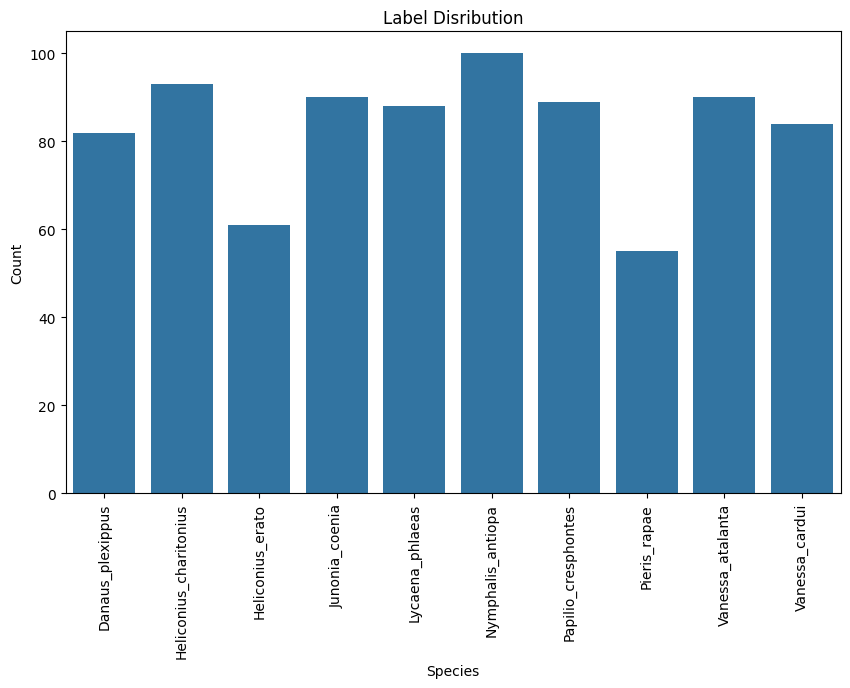

In [11]:
label_count = pds.Series(labels).value_counts().sort_index()
pyt.figure(figsize=(10, 6))
snn.barplot(x=label_count.index, y=label_count.values)
pyt.title('Label Disribution')
pyt.xlabel('Species')
pyt.ylabel('Count')
pyt.xticks(rotation=90)
pyt.show()

The data distribution across classes shows no significant imbalance, so there are no augmentation techniques.

In [12]:
# Preprocessing Images
images = []
for img_name in df['Image']:
    img_path = os.path.join(images_path, img_name)
    img = cv2.imread(img_path)    
    if img is not None:
        img_resized = cv2.resize(img, (224, 224)) #resizng
        img_normalized = img_resized.astype('float32') / 255.0 #normalzing
        images.append(img_normalized)
        
images = nps.array(images)
images.shape

(832, 224, 224, 3)

### **Preprocessing**
The processing stage involves **loading**, **resizing,** and **normalizing.** and the images are resized to 224*224 pixels to ensure a uniform shape. This whole process helps in efficient data handling and ensuring that my data is completely prepared for the model.
- **Normalization** helps the model converge.
- **Labeling** and **image pairing** confirm the correct species label is associated with the image.

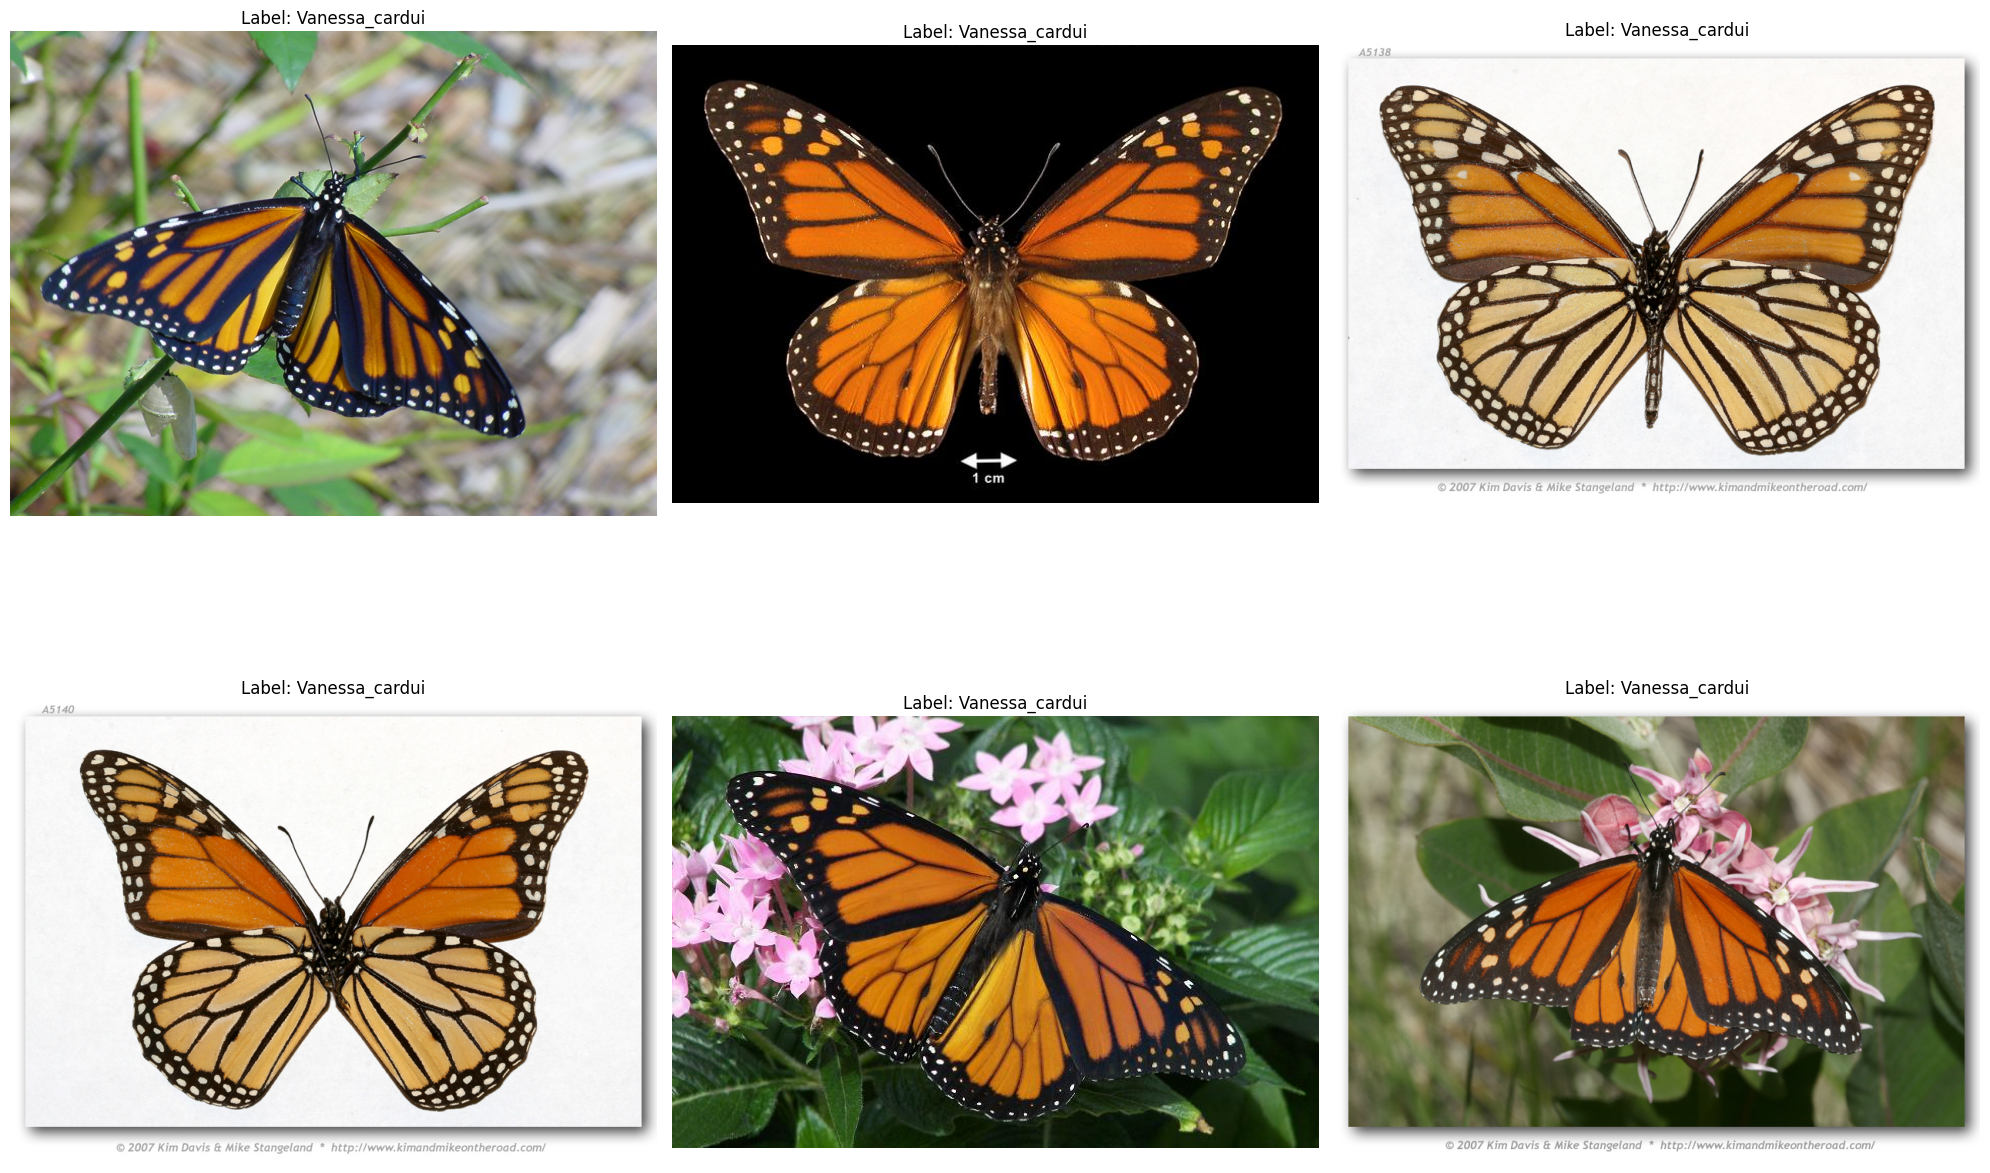

In [13]:
pyt.figure(figsize=(20,15))
for idx in range(6):  
    pyt.subplot(2, 3, idx + 1)  
    img_path = os.path.join(images_path, image_files[idx])  
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    pyt.imshow(img)
    pyt.title(f'Label: {species_name}')
    pyt.axis('off') 
pyt.tight_layout()
pyt.show()

## **Data Division**
- Dividing data into an 80/20 split
- Here, the output shape seems as expected and proves that the split is done and now data is ready for training and testing.

In [14]:
labels = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((665, 224, 224, 3), (167, 224, 224, 3), (665,), (167,))

## **Model Training**

## CNN Model Architecture

After splitting the data, now I am training the model with this custom CNN model that is designed for a classification problem. This model achieved excellent results after employing data augmentation and regularization.

In [15]:
#defning the Model architecture
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5)) 
model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.001)))

The below code compiles the model and trains it

In [16]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

After trying batch normalization, I noticed that this is leading to overfitting, and this didn't help in generalization. Finally, I dropped the idea of using batch normalization and kept dropout layers to improve validation performance as reflected by steadily increasing validation accuracy and decreasing validation loss over epochs. Additionally, after multiple experiments with different approaches, I find that my accuracy was struggling because of a small dataset, so before I train the model, I do data augmentation, which helps in reducing overfitting and increases validation performance.

In [17]:
datagen= ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32), 
    validation_data=(X_test, y_test),
    epochs=25
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 470ms/step - accuracy: 0.0902 - loss: 3.0509 - val_accuracy: 0.1138 - val_loss: 2.6517
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 476ms/step - accuracy: 0.1308 - loss: 2.5743 - val_accuracy: 0.2036 - val_loss: 2.3702
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 514ms/step - accuracy: 0.2376 - loss: 2.3340 - val_accuracy: 0.3473 - val_loss: 2.1305
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 780ms/step - accuracy: 0.2962 - loss: 2.1835 - val_accuracy: 0.4192 - val_loss: 1.8820
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step - accuracy: 0.3474 - loss: 2.0368 - val_accuracy: 0.4850 - val_loss: 1.6917
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - accuracy: 0.3940 - loss: 1.9036 - val_accuracy: 0.4731 - val_loss: 1.7470
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 471ms/step - accuracy: 0.4361 - loss: 1.8788 - val_accuracy: 0.4970 - val_loss: 1.6780
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 476ms/step - accuracy: 0.4737 - loss: 1.7500 - val_accu

This demonstrates that **data augmentation** significantly enhances the generalization. leading to improved performance compared to training without augmentation.Without augmentation, my model accuracy was very good in the final epoch, but the fluctuations were there in validation loss and accuracy and caused overfitting, but with data augmentation I got overall better performance, so I chose this. Also, I tried with 10, 15, and 20 epochs and the 20-epoch model performs the best in validation accuracy and generalization, making it the most effective.

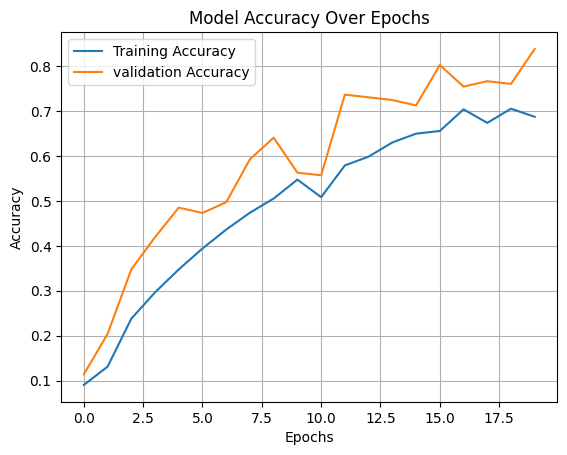

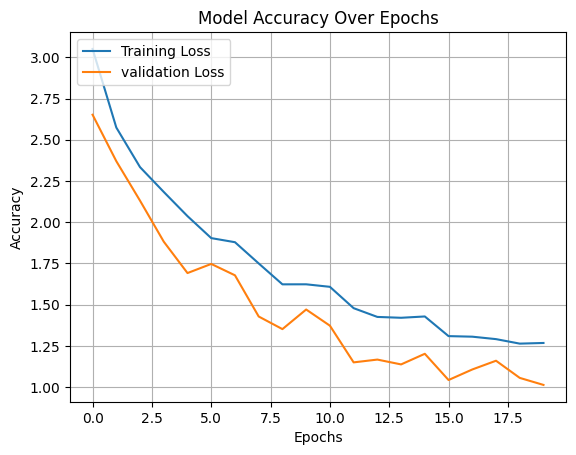

In [19]:
# plotting 

pyt.plot(history.history['accuracy'], label='Training Accuracy') 
pyt.plot(history.history['val_accuracy'], label='validation Accuracy')
pyt.title('Model Accuracy Over Epochs')  
pyt.xlabel('Epochs')  
pyt.ylabel('Accuracy') 
pyt.legend(loc='upper left') 
pyt.grid(True)  
pyt.show()

# Plotting 
pyt.plot(history.history['loss'], label='Training Loss') 
pyt.plot(history.history['val_loss'], label='validation Loss')
pyt.title('Model Accuracy Over Epochs')  
pyt.xlabel('Epochs')  
pyt.ylabel('Accuracy') 
pyt.legend(loc='upper left') 
pyt.grid(True)  

## **Evaluation**

Now, I will evaluate baseline model performance on test data and see the results. it was evaluated on the test dataset to assess accuracy and identify misclassifications.

In [20]:
test_loss, test_accuracy = model.evaluate (X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8383 - loss: 1.0133


As we can see, the test data accuracy is **72.75%**, indicating that the model performs well on unseen data, suggesting good generalization. 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


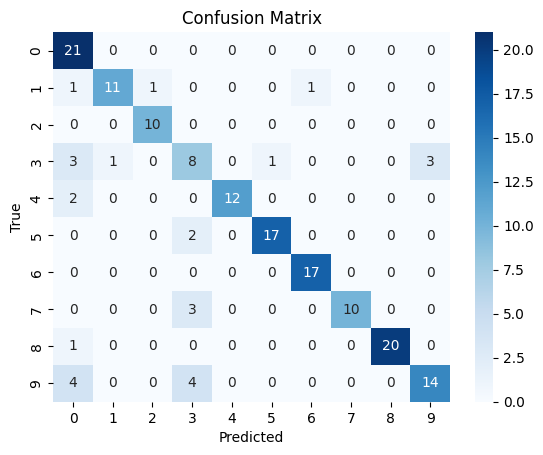

In [21]:
y_pred = model.predict(X_test)
y_pred_classes = nps.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
snn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
pyt.xlabel('Predicted')
pyt.ylabel('True')
pyt.title('Confusion Matrix')
pyt.show()

In [22]:

report_dict = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)
report_df = pds.DataFrame(report_dict).transpose()
from IPython.display import display
display(
    report_df.style.background_gradient(cmap="Blues").format("{:.2f}")
)

I tried different ways to improve my accuracy; however, even after trying regularization, early stopping, and pretrained models, **Pretrained Model**: First tried with The base layer of the pretrained model was frozen, and then I tried to fine-tune these layers to further improve accuracy and reduce loss, but it was not at all good, so I removed that choose to go with the standard CNN model. Seems due to a small dataset, the pretrained model also didn't work out.

## **Model Prediction**

In [23]:
y_pred = model.predict(X_test)
y_pred_classes = nps.argmax(y_pred,axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


In [24]:
sample_image = X_test[0]  
sample_image = nps.expand_dims(sample_image, axis=0) 
predicted_class = model.predict(sample_image)

predicted_class_index = nps.argmax(predicted_class, axis=1)
predicted_species = label_encoder.inverse_transform(predicted_class_index)

f"Predicted Species: {predicted_species[0]}"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


'Predicted Species: Pieris_rapae'

After running the model on a test image, it predicted species.

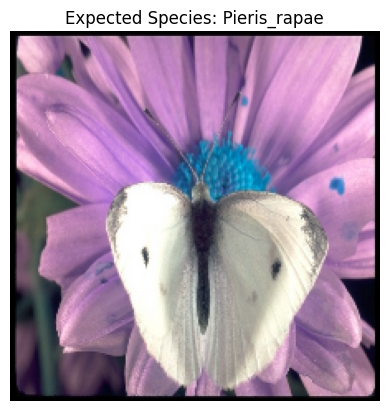

In [25]:
pyt.imshow(sample_image[0])
pyt.title(f'Expected Species: {predicted_species[0]}')
pyt.axis('off')
pyt.show()

### Model Saving
Once the model achieves satisfactory results, we can be saved for future use.

## **Conclusion**
The model achieved promising results and highlights the importance of automated solutions in ecological research. With further enhancements, this system can become an invaluable tool for biodiversity conservation. The CNN model, augmented with regularization and data augmentation, effectively classified butterfly species and demonstrated promising performance for real-world applications.

- A unique aspect of this project was species codes to their scientific names. This approach makes the model's predictions accessible and actionable for end users, including ecologists and researchers who may not be familiar with numeric coding.
- This project was the CNN specifically designed project to handle the small dataset effectively. Pre-trained models, ResNet50 were explored; 

### Final Thoughts

### Performance
- **Custom CNN Model:** Achieved **86.70%** accuracy on test data after training with 20 epochs and data augmentation.
- **Data augmentation** and **L2 regularization** were in mitigating overfitting and improving generalization.
- **Class-Level Insights:** Strong performance across most species, with slight challenges in some classes due to dataset imbalance.

## **Limitations and Recommendations**

**Limitations:**
1. **Dataset Size:** The dataset contains only 832 images, limiting diversity and generalizability.
2. **Class Imbalance:** Uneven representation of species affects model learning for underrepresented classes.
3. **Pre-trained Models:** Due to dataset constraints, heavy pre-trained models like ResNet50 struggled to outperform the custom CNN.
4. **Confusion Among Similar Species:** Some species were misclassified due to visual similarities.


**Recommendations:**
Use a larger and more diverse dataset to improve robustness.

**Business Applications**

This model can automate species identification, reducing manual effort and improving accuracy for ecological studies.
It supports biodiversity monitoring, citizen science projects, and conservation efforts.

In [26]:

model.save('butterfly_model.keras')